Assignment 11: Adversarial Training
===================================


Microsoft Forms Document: https://forms.office.com/r/e3n9gYXsL5

In this assignment we will show that adversarial training provides stability against adversarial attacks for the MNIST dataset.
We will compare three different types of training procedures:

1. Train with only the original samples
2. Train with original samples and added random noise
3. Train with original samples and adversarial samples

Note that the results of this experiment might not translate well to other datasets.

Task 1: Dataset
---------------

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation set.

In [8]:
import torch
import torchvision

# training set and data loader
train_set = torchvision.datasets.MNIST(root='temp', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root='temp', train=False, download=True, transform=torchvision.transforms.ToTensor())
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100)

device = torch.device("cuda")

Task 2: Classification Network
------------------------------
We use the same small-scale network as we have done in assignment 8. 

In [9]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=Q1,kernel_size=5,stride=1,padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1,out_channels=Q2,kernel_size=5,stride=1,padding=2)
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.act = torch.nn.ReLU()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(7*7*Q2, K, bias=True)
    self.fc2 = torch.nn.Linear(K, O, bias=False)

  def forward(self,x):
    a = self.act(self.pool(self.conv1(x)))
    a = self.act(self.pool(self.conv2(a)))
    deep_features = self.fc1(self.flatten(a))
    logits = self.fc2(deep_features)
    return logits

Task 3: Fast Gradient Sign
--------------------------

For adversarial training, we need to implement a function to generate an adversarial sample for a given input.
Here, we are implementing the Fast Gradient Sign method, which modifies the given input by adding a scaled version of the sign of the gradient:

$$\mathbf X_{\mathrm{FGS}} = \mathbf X + \alpha\,\mathrm{sign}(\nabla_{\mathbf X} \mathcal J)$$

Finally, the result needs to be clamped to be in range $[0,1]$.

Note that this function will be used with batches of samples.

In [10]:
def FGS(x, t, network, loss, alpha=0.3):
  # tell autograd that we need the gradient for the input
  X = x.to(device)
  X.requires_grad_(True)

  # forward input
  z = network(X)

  # compute loss and gradient
  J = loss(z,t.to(device))
  J.backward()

  # get the gradient
  gradient = X.grad

  # create FGS adversarial sample
  adversarial_sample = torch.clamp(x + alpha*torch.sign(gradient), min=0, max=1)

  return adversarial_sample

Task 4: Random Noise
--------------------
For comparison, we want a function that produces noise similar to FGS, which we add to the image:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \{-1,1\} ^{D\times E}$$

Here, $-1$ and $1$ are sampled with the same probability, and independently for each pixel.

Again, we clamp the results to be in range $[0,1]$.

Note that this function will also be used with batches of samples.

In [11]:
def noise(x, alpha=0.3, **kwargs):
  x = x.to(device)
  # generate noise
  N = torch.randint(low=0, high=1, size=x.shape, device=device)
  N[N==0] = -1
  # Add noise and clamp
  noisy_sample = torch.clamp(x+alpha*N, min=0, max=1)

  return noisy_sample

Task 5: Training Loop
---------------------

Implement a training and validation loop that possibly includes training with adversarial or with noise samples.
This loop iterates over all training batches once, i.e., we implement one epoch of training here.


In [12]:
def training_loop(network, loss, optimizer, add_additional_samples = None, alpha=0.3):
  train_loss = 0
  adversarial_loss = 0
  network.to(device)
  from tqdm.notebook import tqdm
  for x,t in tqdm(train_loader):
    x = x.to(device)
    optimizer.zero_grad()
    # compute output for current batch
    z = network(x)
    # compute loss
    J = loss(z.to(device), t.to(device))
    train_loss+=J.item()
    # compute gradient
    J.backward()
    optimizer.step()

    if add_additional_samples is not None:
      # compute modified samples for batch
      if add_additional_samples == "FGS":
        # create FGS adversarial samples
        x_hat = FGS(x,t,network,loss,alpha=alpha)

      else:
        # create noisy samples
        x_hat = noise(x, alpha=alpha)
      
      optimizer.zero_grad()
      # compute output for modified samples
      z_hat = network(x_hat.to(device))
      # compute loss on modified samples
      J = loss(z_hat.to(device),t.to(device))
      adversarial_loss+=J.item()
      # compute gradient
      J.backward()
      optimizer.step()

Task 6: Validation Loop
-----------------------

We need to compute both the classification accuracy and the adversarial stability for the validation set.
For each batch, first we select the correctly classified images.
For these, we generate FGS adversarial samples.
Finally, we test whether these adversarial samples are classified as the original classes.

Compute classification accuracy and adversarial accuracy on the whole test set.
Think about how to normalize the adversarial accuracy.

In [13]:
def validation_loop(network, loss, alpha=0.3):
  total, correct_clean_count, correct_adversarial_count = 0,0,0

  # iterate over validation set samples
  for x,t in validation_loader:
    x = x.to(device)
    t = t.to(device)
    total += x.shape[0]
    with torch.no_grad():
      # classify original samples
      z = network(x)
      p = torch.nn.functional.softmax(z, dim=1)
      # compute classification accuracy on original samples
      correct_clean_count += sum(torch.argmax(p,dim=1)==t).item()

    # select the correctly classified samples
    x = x[torch.argmax(p,dim=1)==t]
    t = t[torch.argmax(p,dim=1)==t]

    # create adversarial samples using FGS
    x_FGS = FGS(x,t,network,loss,alpha)

    # check how many are correctly classified
    with torch.no_grad():
      # classify adversarial samples
      z_FGS = network(x_FGS)
      p_FGS = torch.nn.functional.softmax(z_FGS, dim=1)
      # compute classification accuracy on adversarial samples
      correct_adversarial_count += sum(torch.argmax(p_FGS,dim=1)==t).item()

  # compute clean and adversarial accuracy and return them
  clean_accuracy = correct_clean_count / total
  adversarial_accuracy = correct_adversarial_count / total / clean_accuracy
  return clean_accuracy, adversarial_accuracy

Task 7: Training of Three Networks
----------------------------------

Instantiate three different but identical networks.
Instantiate according optimizers that train these networks.
Train these networks for 10 epochs.
The first network will be trained on clean samples only.
The second network will be trained using adversarial samples.
The third network will be trained with noise samples.

Evaluate all three networks on the validation set, and record clean and adversarial classification accuracies.

Note that the training time is extended as compared to a normal training since the creation of adversarial samples requires time.

In [14]:
# define one network for each training procedure
from tqdm.notebook import tqdm
train_plot_clean = []
train_plot_perturb = []
val_plot_clean = []
val_plot_perturb = []
network_clean = Network(Q1=32, Q2=32, K=20, O=10)
network_FGS = Network(Q1=32, Q2=32, K=20, O=10)
network_noise = Network(Q1=32, Q2=32, K=20, O=10)

# define optimizer
optimizer_clean = torch.optim.SGD(params=network_clean.parameters(),lr=0.005)
optimizer_FGS = torch.optim.SGD(params=network_FGS.parameters(),lr=0.005)
optimizer_noise = torch.optim.SGD(params=network_noise.parameters(),lr=0.005)
# define loss function
loss = torch.nn.CrossEntropyLoss()


# store accuracies on clean and adversarial samples for the three cases
clean_accuracies = []
adversarial_accuracies = []


# iterate over 10 epochs (or more)
for epoch in tqdm(range(10)):
  # perform training loop
  training_loop(network_clean, loss, optimizer_clean, add_additional_samples = None, alpha=0.3)
  training_loop(network_FGS, loss, optimizer_FGS, add_additional_samples = "FGS", alpha=0.3)
  training_loop(network_noise, loss, optimizer_noise, add_additional_samples = "noise", alpha=0.3)

  # compute and store validation set accuracies
  clean_accuracies_clean, adv_accuracies_clean = validation_loop(network_clean,loss)
  clean_accuracies_FGS, adv_accuracies_FGS = validation_loop(network_FGS,loss)
  clean_accuracies_noise, adv_accuracies_noise = validation_loop(network_noise,loss)
  clean_accuracies.append((clean_accuracies_clean,clean_accuracies_FGS,clean_accuracies_noise))
  adversarial_accuracies.append((adv_accuracies_clean, adv_accuracies_FGS, adv_accuracies_noise))
  print(f"\rEpoch {epoch}| clean_accuracies: {clean_accuracies_clean:1.5f}; adv_accuracies_FGS: {adv_accuracies_FGS:1.5f}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 0| clean_accuracies: 0.91030; adv_accuracies_FGS: 0.39000



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1| clean_accuracies: 0.94380; adv_accuracies_FGS: 0.49329



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2| clean_accuracies: 0.95950; adv_accuracies_FGS: 0.60048



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3| clean_accuracies: 0.97100; adv_accuracies_FGS: 0.67337



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4| clean_accuracies: 0.97510; adv_accuracies_FGS: 0.76940



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5| clean_accuracies: 0.97700; adv_accuracies_FGS: 0.68654



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6| clean_accuracies: 0.98220; adv_accuracies_FGS: 0.74521



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7| clean_accuracies: 0.98020; adv_accuracies_FGS: 0.73962



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8| clean_accuracies: 0.98210; adv_accuracies_FGS: 0.83152



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9| clean_accuracies: 0.98430; adv_accuracies_FGS: 0.80364



Task 8: Plotting of Accuracies
------------------------------

Plot the different clean accuracies and adversarial accuracies over the training epochs.

Text(0, 0.5, 'Adversarial Accuracy')

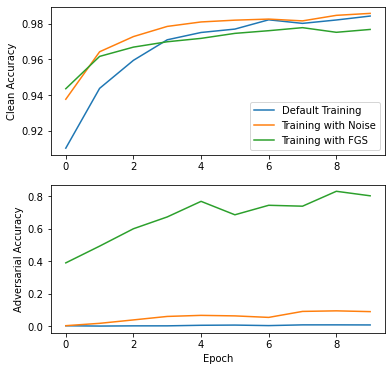

In [16]:
from matplotlib import pyplot
import numpy

pyplot.figure(figsize=(6, 6))

clean_accuracies = numpy.array(clean_accuracies)
adversarial_accuracies = numpy.array(adversarial_accuracies)

# plot clean accuracies
ax = pyplot.subplot(211)
ax.plot(clean_accuracies[:,0], label="Default Training")
ax.plot(clean_accuracies[:,2], label="Training with Noise")
ax.plot(clean_accuracies[:,1], label="Training with FGS")
ax.set_ylabel("Clean Accuracy")
ax.legend()

# plot adversarial accuracies
ax = pyplot.subplot(212)
ax.plot(adversarial_accuracies[:,0])
ax.plot(adversarial_accuracies[:,2])
ax.plot(adversarial_accuracies[:,1])
ax.set_xlabel("Epoch")
ax.set_ylabel("Adversarial Accuracy")